In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

In [ ]:
def assessment(data, y_feature, x_feature, index=-1):
    """
    This is a visualization function to show histograms and scatter plots of each features.
    """
    for row in data:
        if index >= 0:
            color = np.where(data[row].index == index,'r','g')
            hue = None
        else:
            color = 'b'
            hue = None
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    chart1 = sns.histplot(data[x_feature], ax=axes[0], kde=False, color='g')
    chart1.set_xlabel(x_feature, fontsize=10)
    if index >= 0:
        chart2 = plt.scatter(data[x_feature], data[y_feature], c=color, edgecolors='w')
        chart2 = plt.xlabel(x_feature, fontsize=10)
        chart2 = plt.ylabel(y_feature, fontsize=10)
    else:
        chart2 = sns.scatterplot(x=x_feature, y=y_feature, data=data, hue=hue, legend=False)
        chart2.set_xlabel(x_feature,fontsize=10)
        chart2.set_ylabel(y_feature,fontsize=10)
    plt.show()

In [ ]:
def correlation_map(data, feature, number):
    """
    This function generate a heatmap showing correlations.
    """
    most_correlated = data.corr().nlargest(number, feature)[feature].index
    correlation = data[most_correlated].corr()

    mask = np.zeros_like(correlation)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        fig, axes = plt.subplots(figsize=(20, 10))
        sns.heatmap(
            correlation,
            mask=mask,
            vmin=-1,
            vmax=1,
            square=True,
            center=0,
            annot=True,
            annot_kws={"size": 8},
            cmap="PRGn",
        )
    plt.show()

In [ ]:
#Connecting to google drive
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
grid = pd.read_csv("./dataset/smart_grid_stability_augmented.csv")
weather = pd.read_csv("./dataset/oyo_weather_2024.csv", parse_dates=["datetime"])

# Creating synthetic datetime series for grid data
start_time = weather["datetime"].min()
grid["datetime"] = pd.date_range(start=start_time, periods=len(grid), freq="min")

# Merge based on nearest timestamp
merged = pd.merge_asof(
    grid.sort_values("datetime"),
    weather.sort_values("datetime"),
    on="datetime",
    direction="nearest"
)

merged.to_csv("./dataset/smartgrid_weather_merged.csv", index=False)
print("Successfully merged all rows, you can have glimpse below")
print(merged.head())

Successfully merged all rows, you can have glimpse below
       tau1      tau2      tau3      tau4        p1        p2        p3  \
0  2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1  9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2  8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3  0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4  3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   

         p4        g1        g2  ...  WD10M  WS50M  WD50M ALLSKY_SFC_SW_DWN  \
0 -1.723086  0.650456  0.859578  ...  170.9   2.07  171.4               0.0   
1 -1.255012  0.413441  0.862414  ...  170.9   2.07  171.4               0.0   
2 -0.920492  0.163041  0.766689  ...  170.9   2.07  171.4               0.0   
3 -0.997374  0.446209  0.976744  ...  170.9   2.07  171.4               0.0   
4 -0.554305  0.797110  0.455450  ...  170.9   2.07  171.4               0.0   

  ALLSKY_SFC_LW_D

In [ ]:
# Loading and preprocessing the data
data = pd.read_csv("/content/drive/MyDrive/dataset/smartgrid_weather_merged.csv")
map1 = {"unstable": 0, "stable": 1}
data["stabf"] = data["stabf"].replace(map1)
data = data.sample(frac=1)

/tmp/ipython-input-3686604599.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["stabf"] = data["stabf"].replace(map1)


In [ ]:
print(data.head())

           tau1      tau2      tau3      tau4        p1        p2        p3  \
855    3.576317  9.074529  5.291465  3.630796  3.720034 -1.339835 -1.477834   
47609  7.422466  2.689001  1.082814  6.394074  2.933215 -1.434208 -0.848453   
491    5.977964  3.872035  6.508813  9.186981  3.304232 -0.850337 -0.761407   
49442  2.008187  6.243975  1.615061  6.064221  4.009381 -0.951187 -1.236998   
52237  9.488435  0.913480  3.715132  1.803215  2.163930 -0.580261 -0.757135   

             p4        g1        g2  ...  WD10M  WS50M  WD50M  \
855   -0.902365  0.170296  0.415657  ...   67.6   1.99   66.7   
47609 -0.650555  0.306998  0.255283  ...   46.0   3.42   45.7   
491   -1.692488  0.279811  0.101680  ...  349.3   2.72  347.0   
49442 -1.821197  0.081420  0.132927  ...   41.7   5.06   42.0   
52237 -0.826534  0.349221  0.901006  ...   45.4   5.78   45.6   

       ALLSKY_SFC_SW_DWN ALLSKY_SFC_LW_DWN  ALLSKY_KT  PRECTOTCORR     PS  \
855               522.85            409.25       0.58    

In [ ]:
X_dataframe = data.drop('stabf', axis=1)
y_dataframe = data['stabf']

In [ ]:
data.columns

Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'stabf', 'datetime', 'T2M', 'T2MDEW', 'T2MWET',
       'RH2M', 'WS10M', 'WD10M', 'WS50M', 'WD50M', 'ALLSKY_SFC_SW_DWN',
       'ALLSKY_SFC_LW_DWN', 'ALLSKY_KT', 'PRECTOTCORR', 'PS', 'CLOUD_AMT',
       'TOA_SW_DWN'],
      dtype='object')

In [ ]:
data["datetime"] = pd.to_datetime(data["datetime"])
data["datetime"].dtypes

dtype('<M8[ns]')

In [ ]:
# converting datetime to float compatible for my neural network.
data["datetime"] = data["datetime"].astype("int64") / 1e9

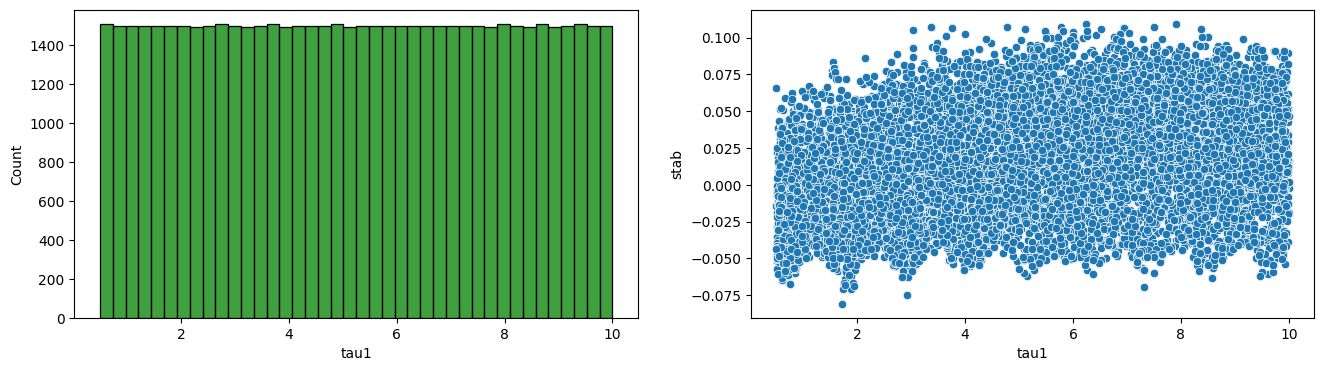

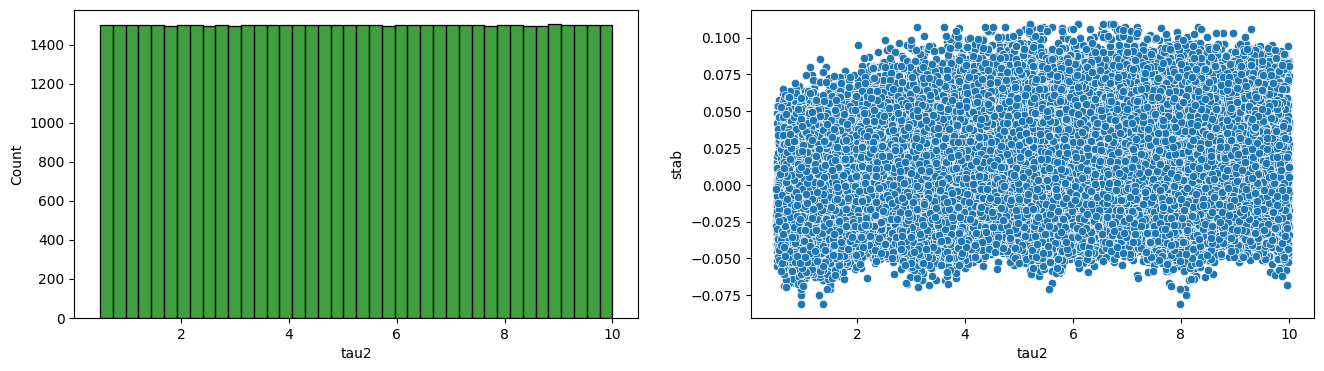

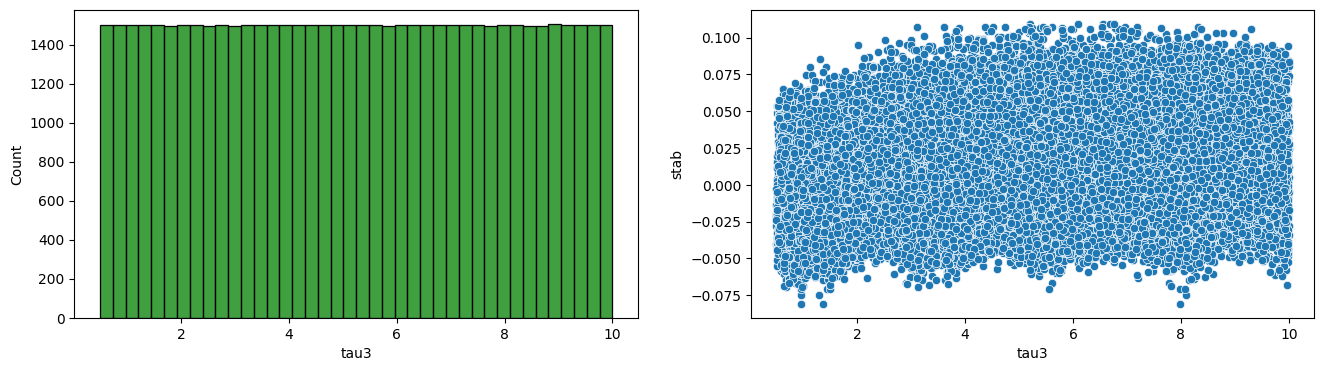

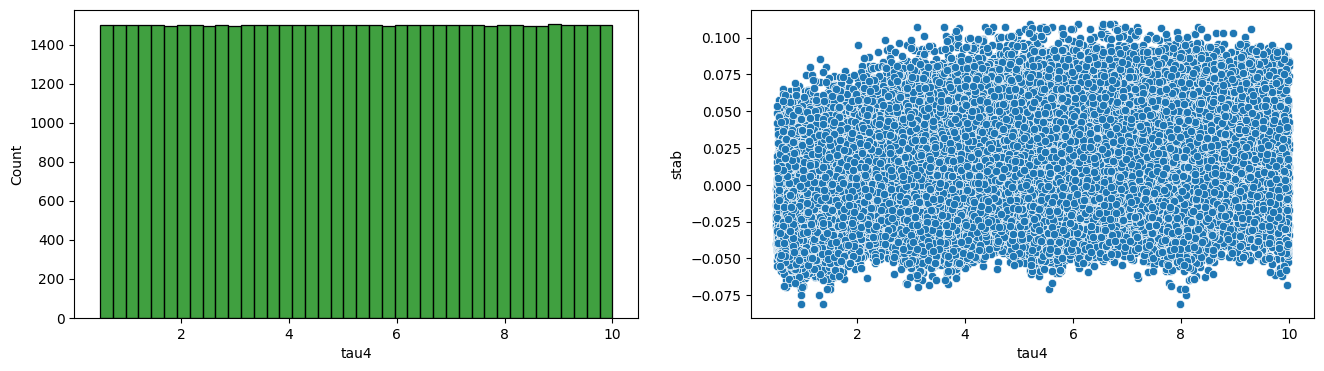

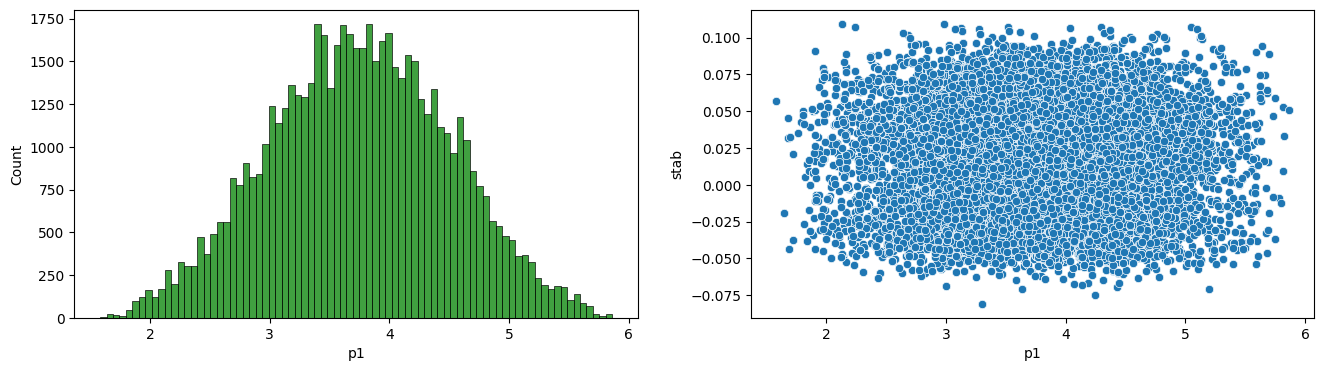

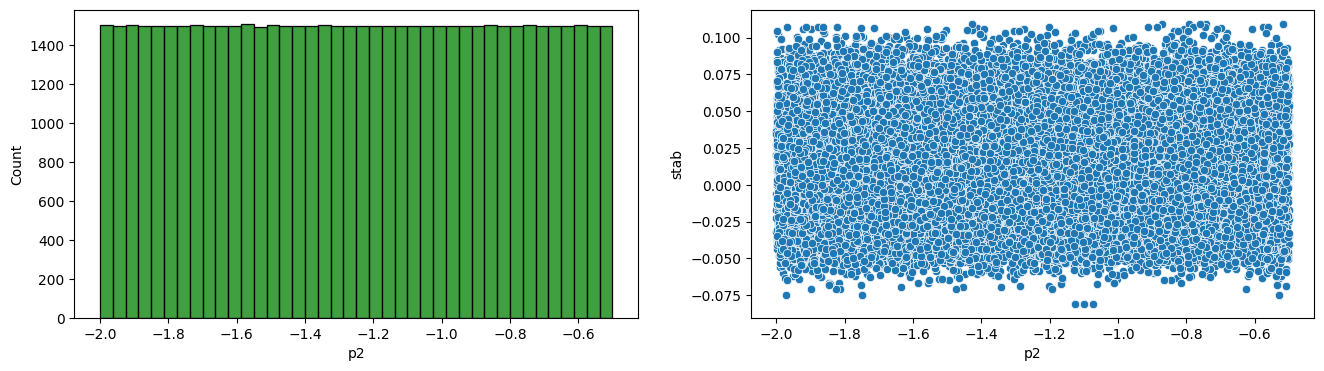

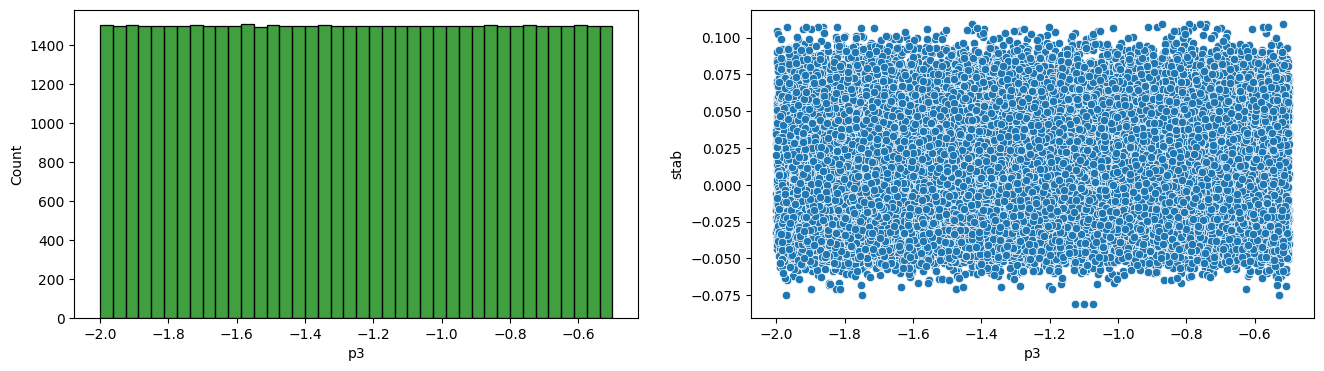

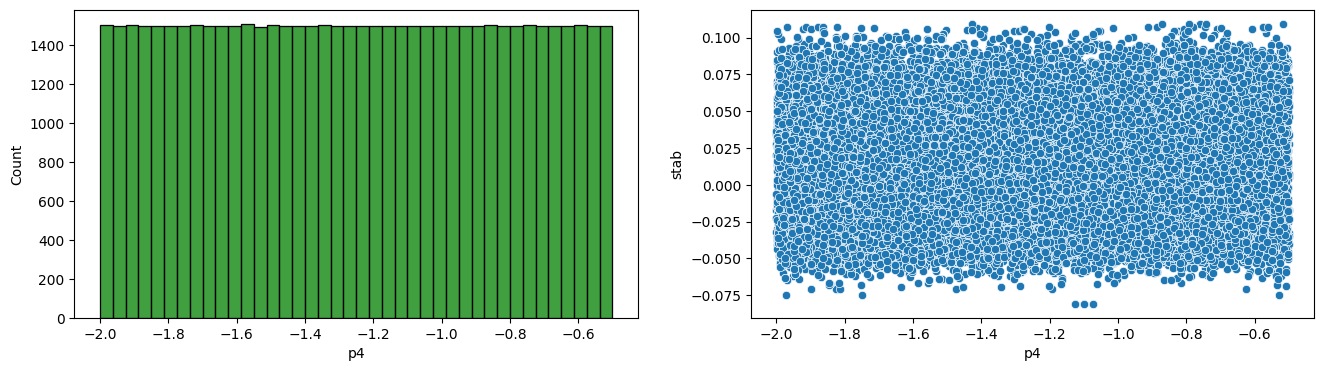

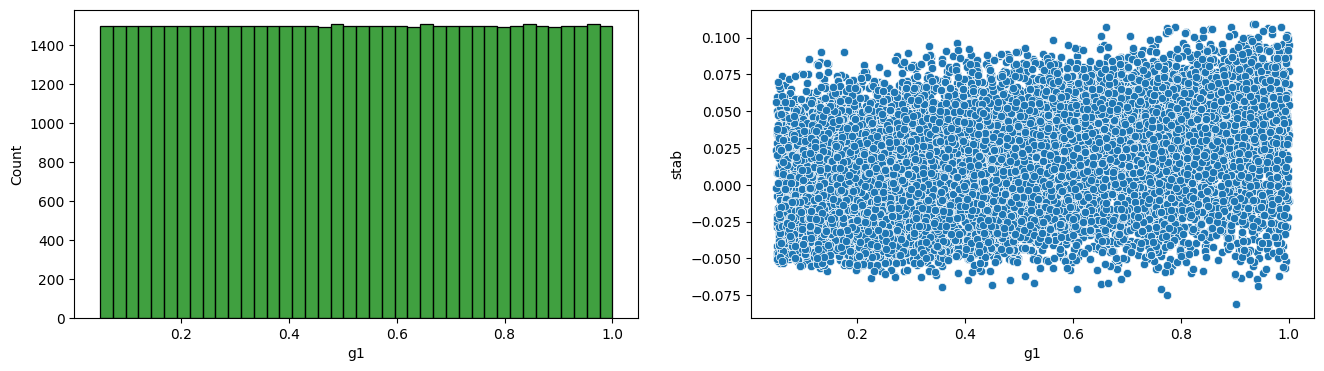

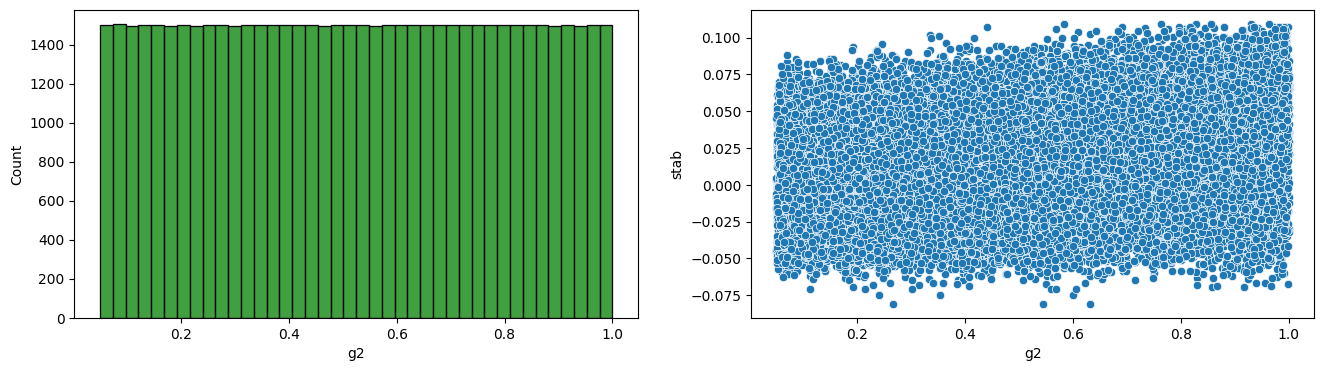

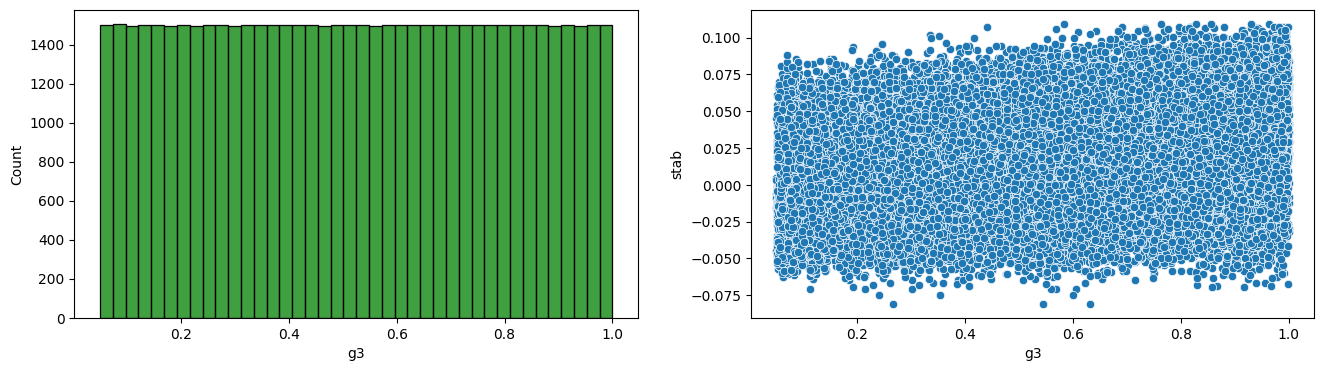

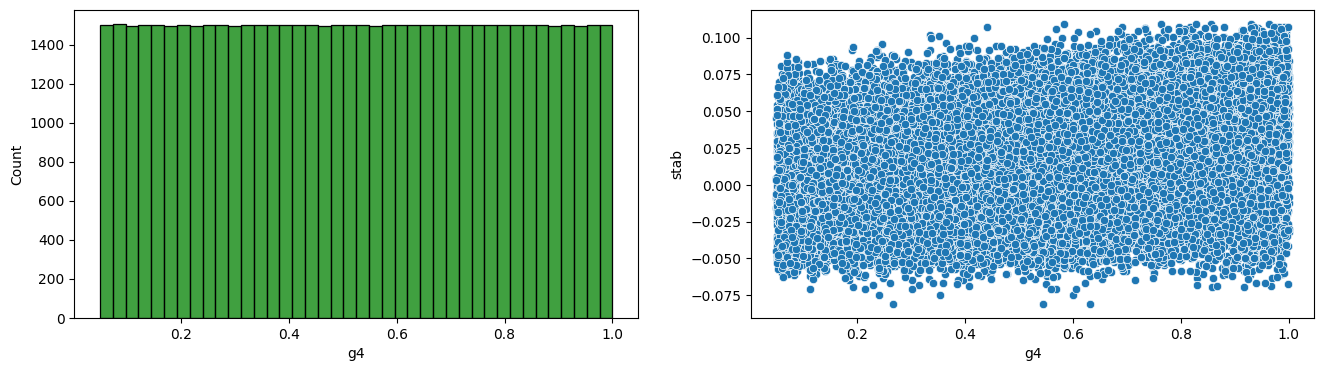

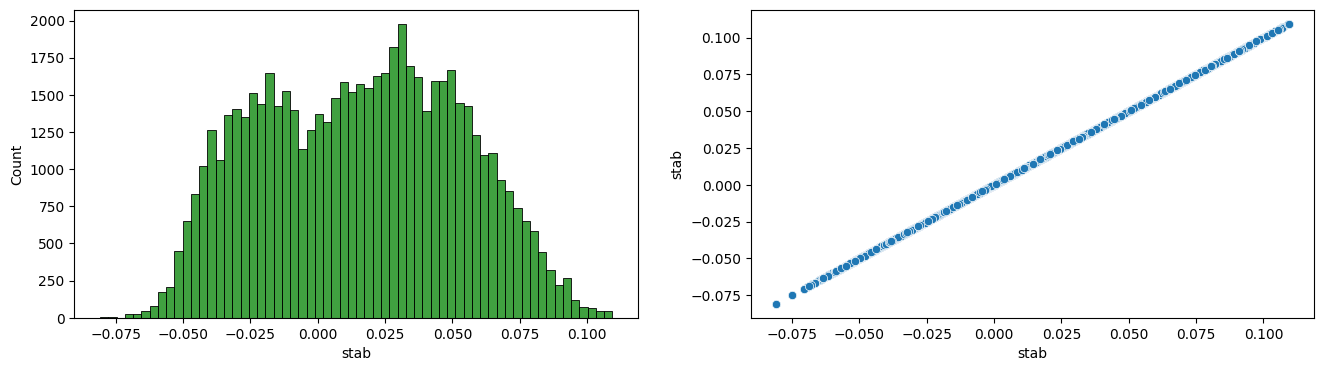

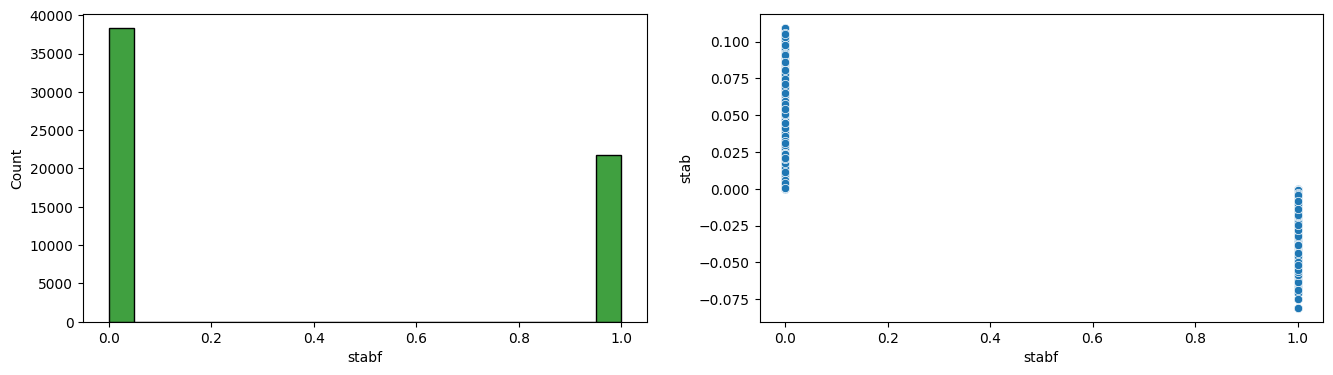

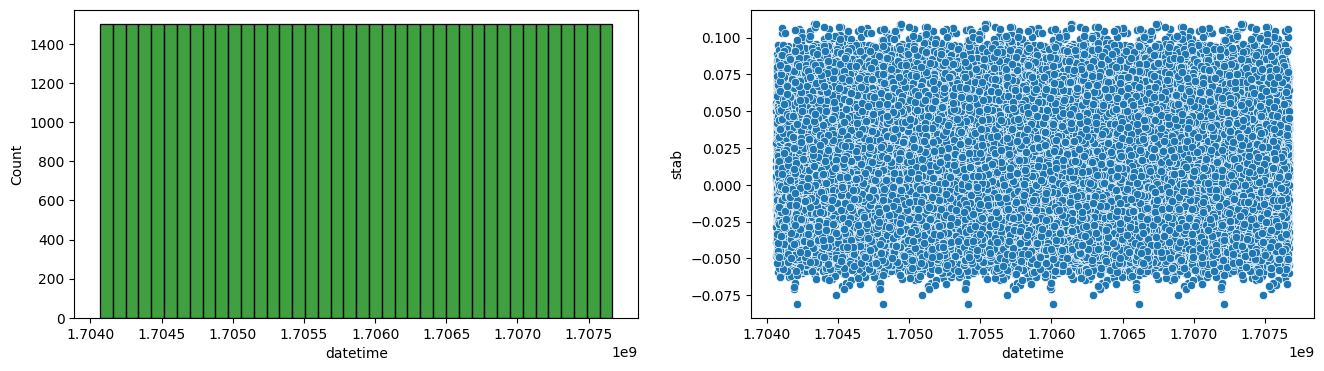

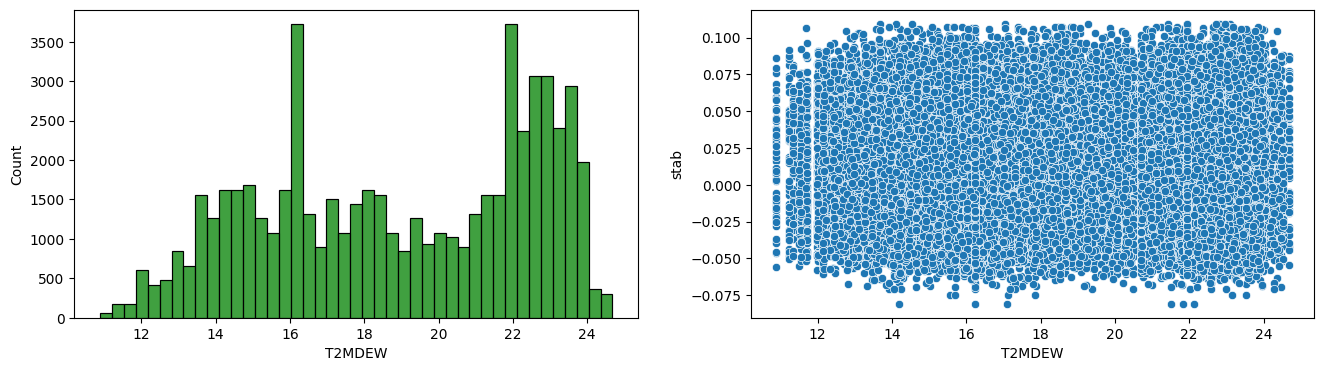

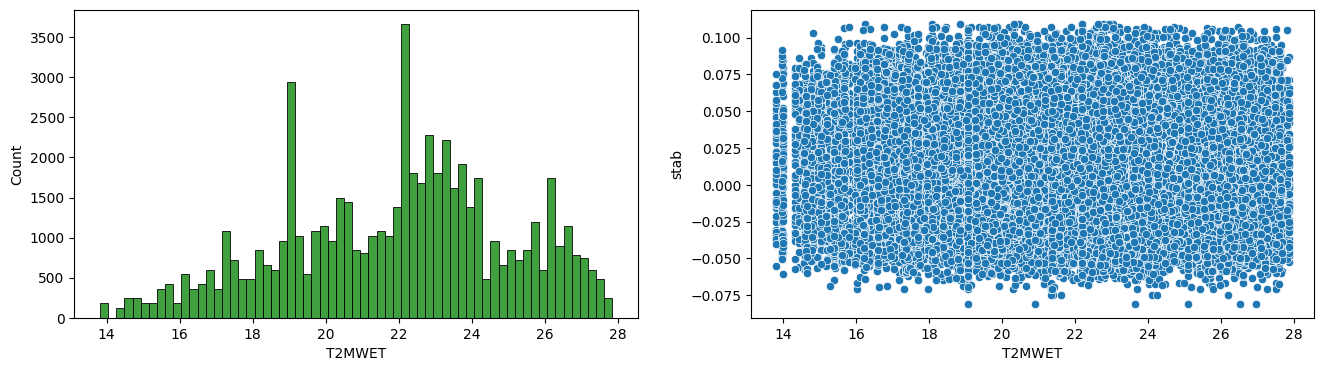

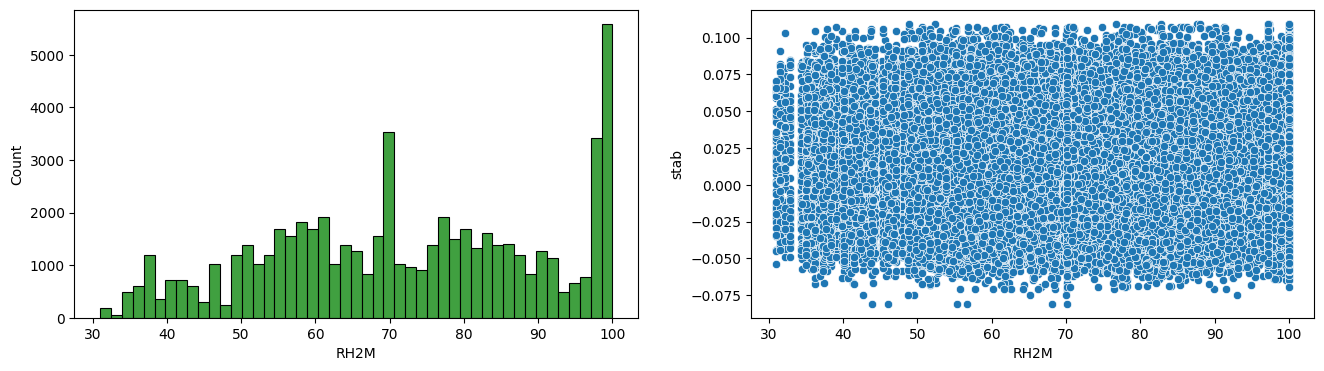

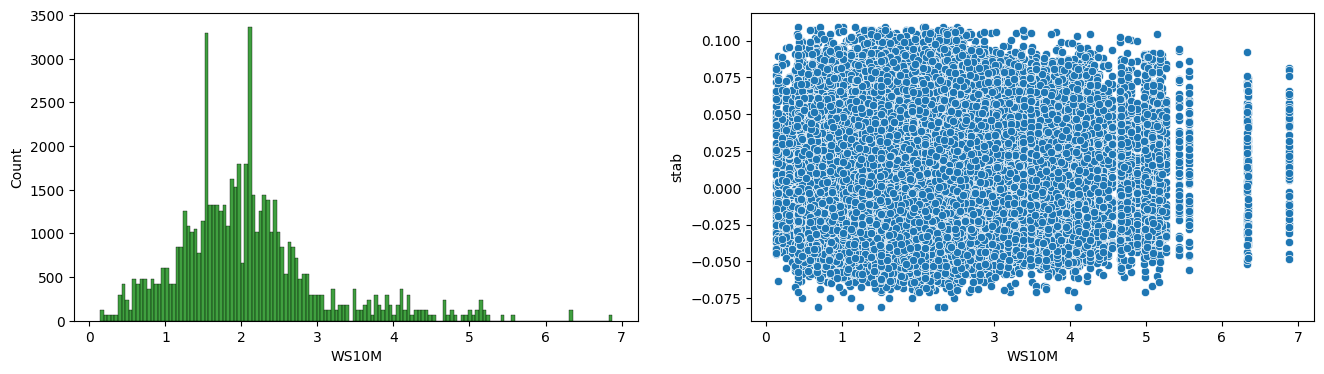

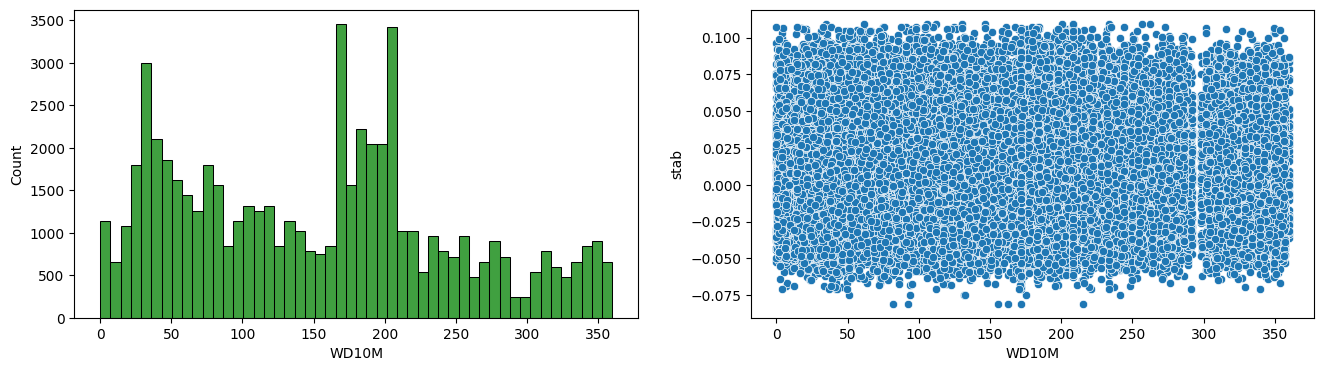

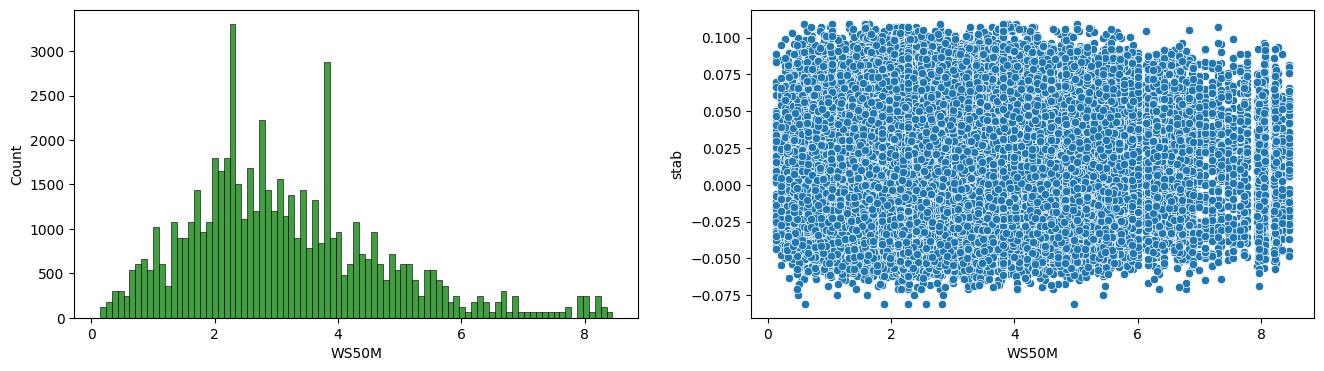

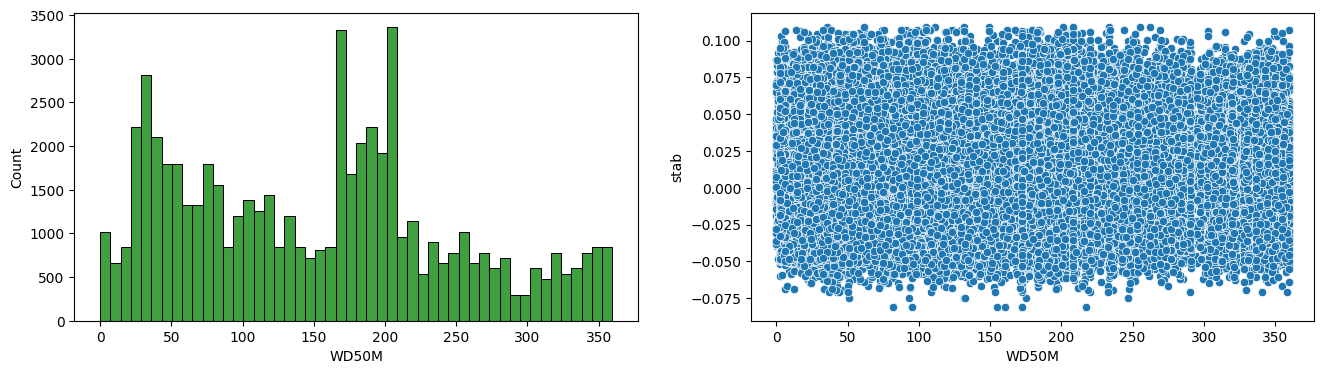

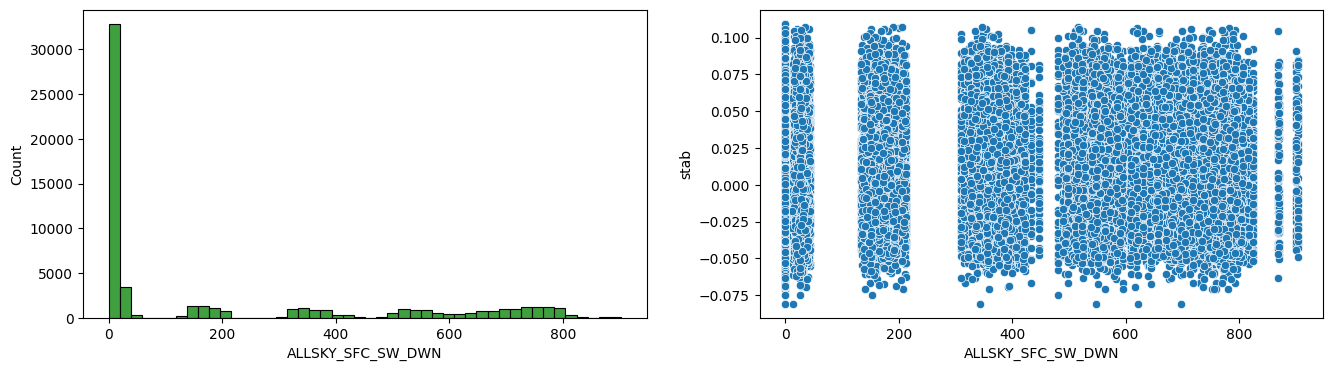

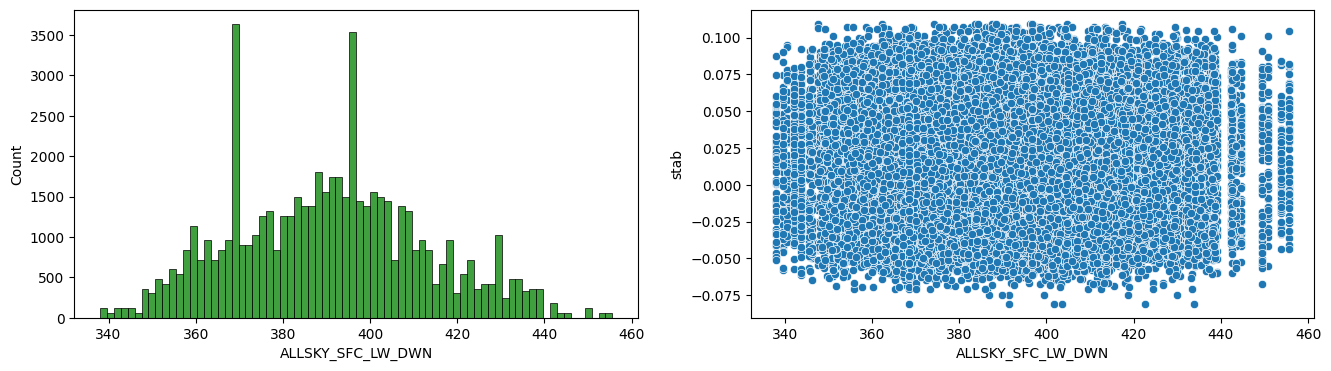

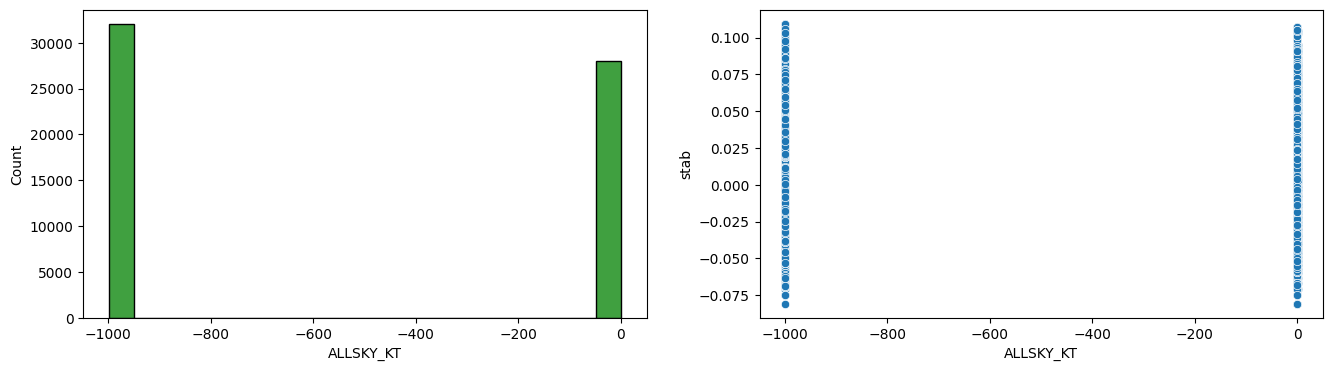

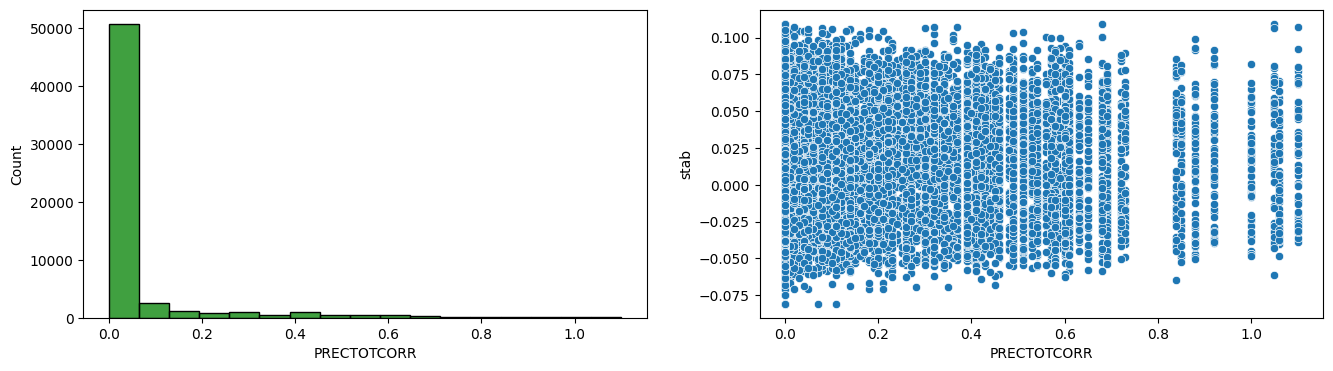

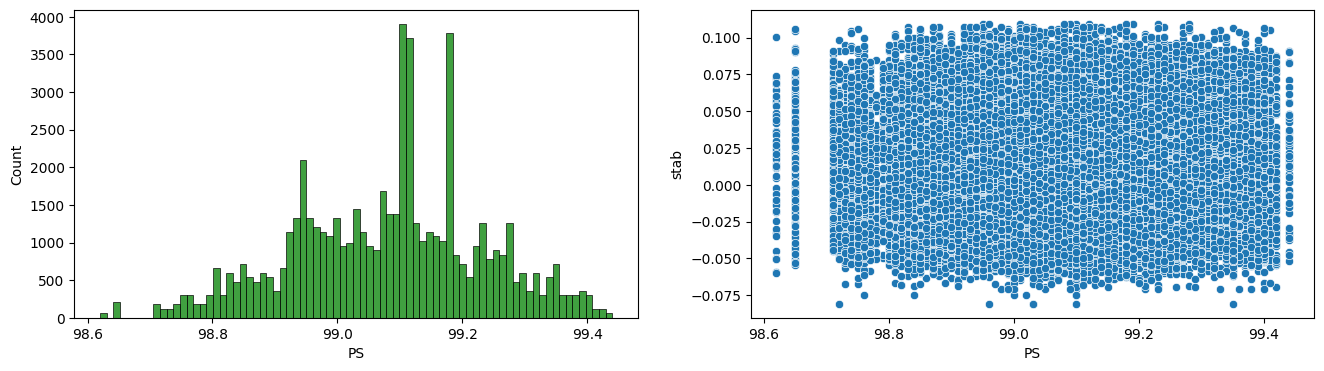

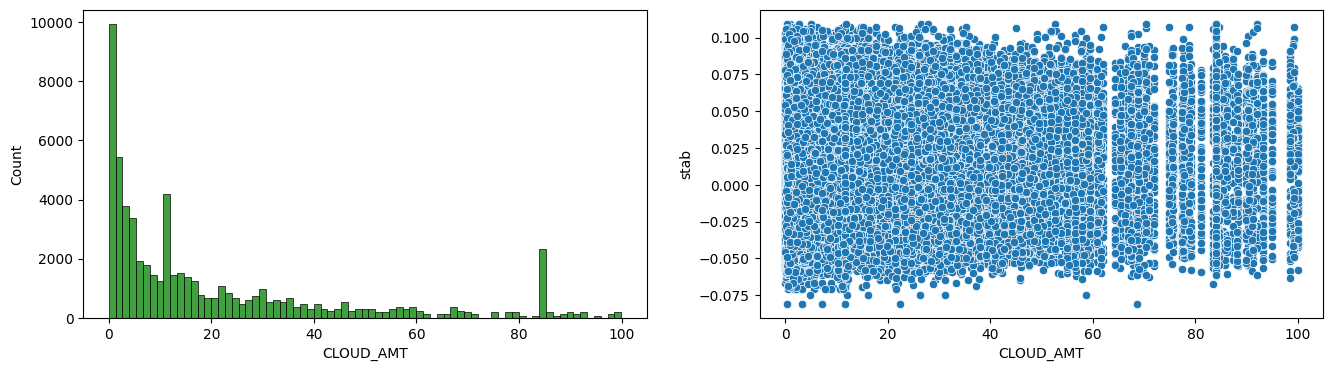

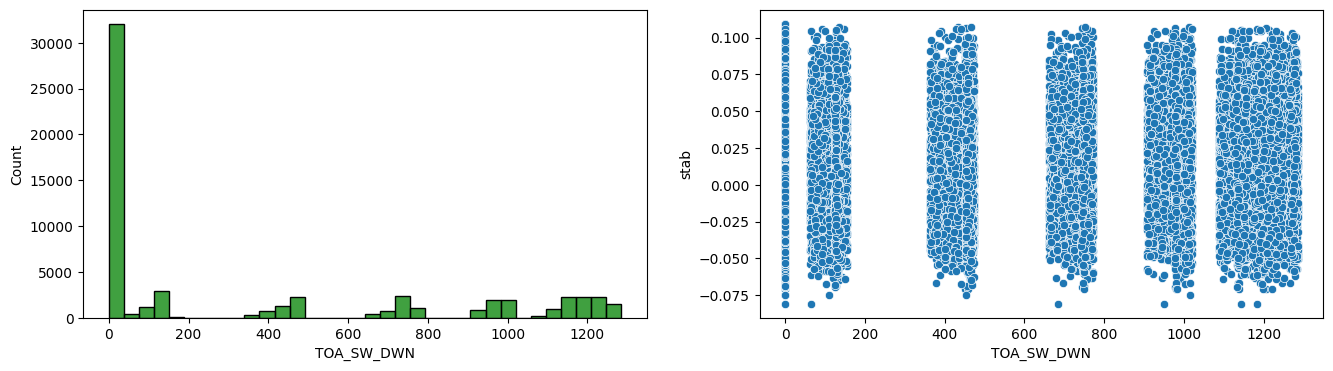

In [ ]:
for col in data.columns:
    assessment(data, "stab", col, -1)

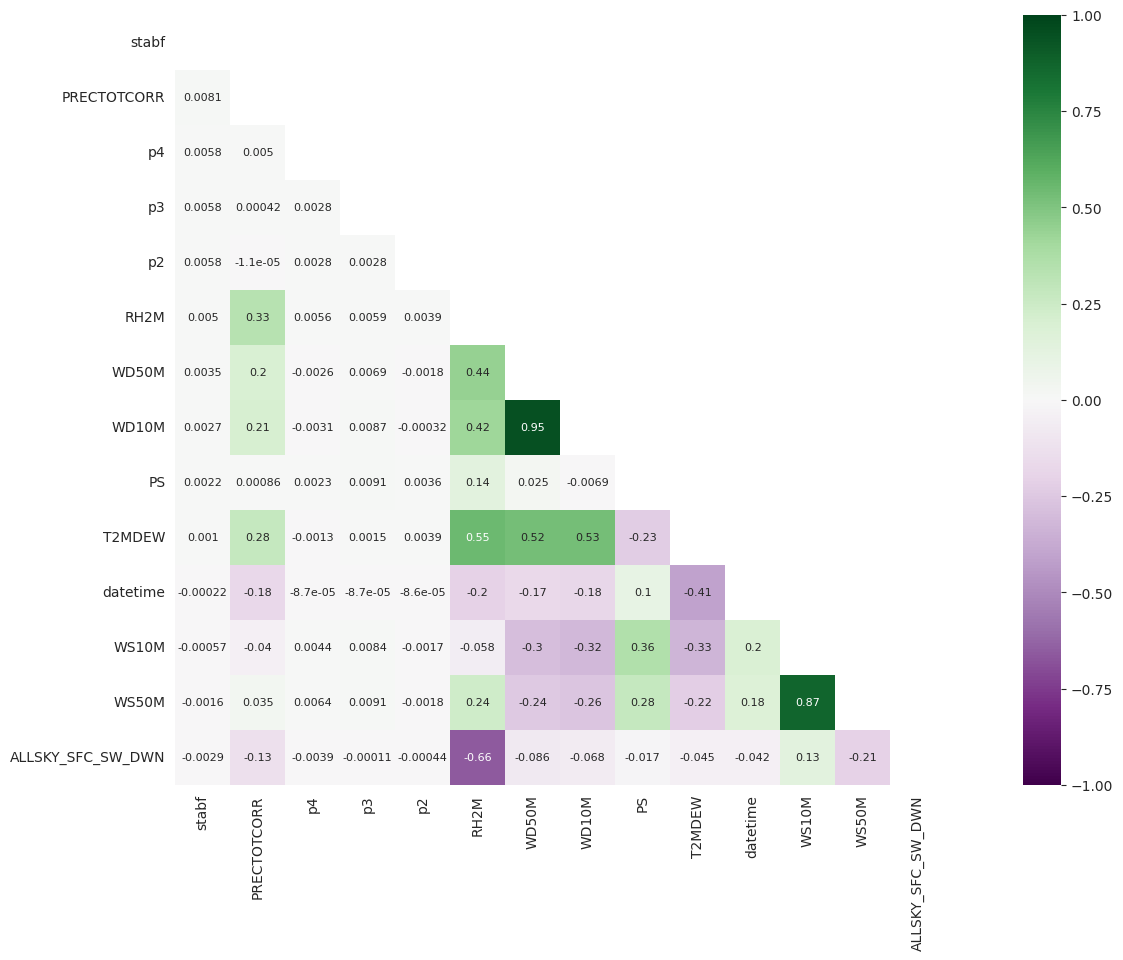

In [ ]:
#Checking the correlation of the features
correlation_map(data, 'stabf', 14)

In [ ]:
print('Spliting of Stable (0) and Unstable (1) observation in the dataset')
print(data['stabf'].value_counts(normalize=True))

Spliting of Stable (0) and Unstable (1) observation in the dataset
stabf
0    0.638
1    0.362
Name: proportion, dtype: float64


In [ ]:
X = data.iloc[:, :12].values
y = data.iloc[:, 13].values

In [ ]:
X_train, X_test = X[:54000], X[54000:]
y_train, y_test = y[:54000], y[54000:]

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
# Defining the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(12, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 24)
        self.fc4 = nn.Linear(24, 1)
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.elu(self.fc2(x))
        x = self.elu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [ ]:
# Initializing the model, loss function, and optimizer
model = NeuralNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Cross-validation
kf = KFold(15, shuffle=True, random_state=10)
start_time = datetime.now()
print("Model evaluation\n")

Model evaluation



In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    x_train, x_val = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val = y_train[train_idx], y_train[val_idx]
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train_fold)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)
        val_accuracy = accuracy_score(y_val.numpy(), (val_outputs.numpy() > 0.5).astype(int))
        print(f"Fold {fold + 1} - Loss: {val_loss:.4f} | Accuracy: {val_accuracy * 100:.2f}%")

Fold 1 - Loss: 0.3910 | Accuracy: 81.94%
Fold 2 - Loss: 0.3567 | Accuracy: 83.92%
Fold 3 - Loss: 0.2465 | Accuracy: 90.11%
Fold 4 - Loss: 0.1475 | Accuracy: 94.28%
Fold 5 - Loss: 0.1039 | Accuracy: 96.14%
Fold 6 - Loss: 0.0801 | Accuracy: 96.81%
Fold 7 - Loss: 0.0668 | Accuracy: 97.56%
Fold 8 - Loss: 0.0504 | Accuracy: 98.17%
Fold 9 - Loss: 0.0536 | Accuracy: 98.03%
Fold 10 - Loss: 0.0432 | Accuracy: 98.58%
Fold 11 - Loss: 0.0360 | Accuracy: 98.67%
Fold 12 - Loss: 0.0408 | Accuracy: 98.44%
Fold 13 - Loss: 0.0365 | Accuracy: 98.47%
Fold 14 - Loss: 0.0348 | Accuracy: 98.86%
Fold 15 - Loss: 0.0352 | Accuracy: 99.06%


In [ ]:
# Testing the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = (y_pred.numpy() > 0.5).astype(int)
    cm = confusion_matrix(y_test.numpy(), y_pred)
    test_accuracy = accuracy_score(y_test.numpy(), y_pred)

print(f"\nConfusion Matrix:\n{cm}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

end_time = datetime.now()
print("\nStart time", start_time)
print("End time", end_time)
print("Time elapsed", end_time - start_time)


Confusion Matrix:
[[3794   31]
 [  51 2124]]
Test Accuracy: 98.63%

Start time 2025-10-25 08:19:39.369953
End time 2025-10-25 08:20:41.951178
Time elapsed 0:01:02.581225


In [ ]:
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
print(cm)

                 Predicted Unstable  Predicted Stable
Actual Unstable                3794                31
Actual Stable                    51              2124


In [ ]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_test) * 100):.2f}%')

Accuracy per the confusion matrix: 98.63%


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3825
         1.0       0.99      0.98      0.98      2175

    accuracy                           0.99      6000
   macro avg       0.99      0.98      0.99      6000
weighted avg       0.99      0.99      0.99      6000

